In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**問題1　クロスバリデーション**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)

In [4]:
application_train = pd.read_csv("drive/My Drive/application_train.csv")
application_test = pd.read_csv("drive/My Drive/application_test.csv")

categorical_list = []
numerical_list = []

for i in application_train.columns.tolist():
    if application_train[i].dtype=="object":
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 16
Number of numerical features: 106


In [5]:
from sklearn.impute import SimpleImputer

application_train[numerical_list].isnull().sum().sum()

application_train[numerical_list] = SimpleImputer(strategy="median").fit_transform(application_train[numerical_list])

In [6]:
application_train[numerical_list].isnull().sum().sum()

0

In [7]:
application_train.shape

(307511, 122)

In [8]:
application_train = pd.get_dummies(application_train, drop_first=True)

In [9]:
application_train.shape

(307511, 230)

In [10]:
application_train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,9.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,9.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311267,0.622246,0.535276,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,26.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505998,0.555912,0.729567,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,9.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505998,0.650442,0.535276,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,9.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,1.0,1.0,0.505998,0.322738,0.535276,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327.0,-236.0,-8456.0,-1982.0,9.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,15.0,0.0,

In [11]:
application_train.isnull().sum().sum()

0

In [12]:
application_test = pd.get_dummies(application_test, drop_first=True)
print(application_test.shape)

(48744, 226)


In [13]:
import re
application_train = application_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [14]:
application_train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_SecurityMinistries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Tradetype1,ORGANIZATION_TYPE_Tradetype2,ORGANIZATION_TYPE_Tradetype3,ORGANIZATION_TYPE_Tradetype4,ORGANIZATION_TYPE_Tradetype5,ORGANIZATION_TYPE_Tradetype6,ORGANIZATION_TYPE_Tradetype7,ORGANIZATION_TYPE_Transporttype1,ORGANIZATION_TYPE_Transporttype2,ORGANIZATION_TYPE_Transporttype3,ORGANIZATION_TYPE_Transporttype4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_orgspecaccount,FONDKAPREMONT_MODE_regoperaccount,FONDKAPREMONT_MODE_regoperspecaccount,HOUSETYPE_MODE_specifichousing,HOUSETYPE_MODE_terracedhouse,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,9.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,9.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311267,0.622246,0.535276,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,26.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505998,0.555912,0.729567,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,9.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505998,0.650442,0.535276,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,9.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,1.0,1.0,0.505998,0.322738,0.535276,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327.0,-236.0,-8456.0,-1982.0,9.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145570,0.681632,0.535276,0

In [15]:
X = application_train.drop(['TARGET','CODE_GENDER_XNA', 'NAME_INCOME_TYPE_Maternityleave', 'NAME_FAMILY_STATUS_Unknown'], axis=1)
y = application_train.TARGET

In [16]:
import warnings
warnings.simplefilter("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

std = StandardScaler()
clf = LogisticRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=None)

scores = []

for idx_tr, idx_va in kf.split(X):
    X_train, X_test = X.iloc[idx_tr], X.iloc[idx_va]
    #print(X_train.shape, X_test.shape)
    y_train, y_test = y.iloc[idx_tr], y.iloc[idx_va]
    #print(X_train.shape, X_test.shape)
    X_train_std = std.fit_transform(X_train)
    X_test_std = std.transform(X_test)
    clf.fit(X_train_std, y_train)
    y_pred = clf.predict_proba(X_test_std)[:,1]
    score = roc_auc_score(y_test, y_pred)

print("AUC mean:", np.mean(score))

AUC mean: 0.745533826474113


In [17]:
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve


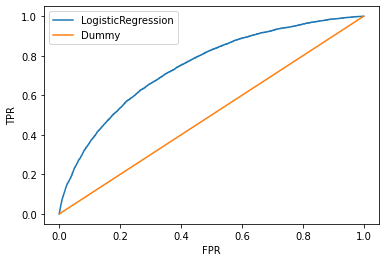

In [18]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train_std, y_train)

fpr_grid, tpr_grid, thresholds_grid = roc_curve(y_test, clf.decision_function(X_test_std))
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test, dummy_majority.predict_proba(X_test_std)[:,1])

plt.plot(fpr_grid, tpr_grid, label="LogisticRegression")
plt.plot(fpr_dummy, tpr_dummy, label="Dummy")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()


#**問題2　グリッドサーチ**

In [ ]:
import scipy.stats
#from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from google.colab import files
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

model_param = {
    LogisticRegression(max_iter=50000): {
        "C": [10**i for i in range(-4,4)],
        "random_state": [42],
    },
    
    #SVC(): {
     #   "kernel": ["rbf"],
     #   "C": [0.01, 0.1, 1.0, 10, 100],
     #   "decision_function_shape": ["ovr"],
     #   "random_state": [42]
    #},
    #DecisionTreeClassifier(): {
     #   "max_depth": [i for i in range(1, 20)],
    #},
    #RandomForestClassifier(): {
     #   "n_estimators": [i for i in range(10, 20)],
     #   "max_depth": [i for i in range(1, 10)],
    #},
    #KNeighborsClassifier(): {
     #   "n_neighbors": [i for i in range(1, 10)]
    #}
}

max_score = 0
best_model = None
best_param = None


dummy_majority = DummyClassifier(strategy='most_frequent').fit(train_X, train_y)

for model, param in model_param.items():
    clf = GridSearchCV(model, param, cv=10, verbose=2, scoring="roc_auc")
    clf.fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    #print(pred_y.shape)
    #print(test_y.shape)
    score = accuracy_score(test_y, pred_y)


    if max_score < score:
        max_score = score
        #モデルのクラス名を取得
        best_model = model.__class__.__name__
        best_param = clf.best_params_

print("学習モデル:{}".format(best_model))
print("パラメーター：{}".format(best_param))
print("ベストスコア:",max_score)

y_pred = clf.predict_proba(test_X_features)
#print(y_pred[:,1].shape)
#print(test_y.shape)

print(test_y.shape)
print(test_X.shape)
fpr_grid, tpr_grid, thresholds_grid = roc_curve(test_y, clf.decision_function(test_X))
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(test_y, dummy_majority.predict_proba(test_X)[:,1])

plt.plot(fpr_grid, tpr_grid, label="LogisticRegression")
plt.plot(fpr_dummy, tpr_dummy, label="Dummy")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()


Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] C=0.0001, random_state=42 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................ C=0.0001, random_state=42, total=  29.8s
[CV] C=0.0001, random_state=42 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.8s remaining:    0.0s


[CV] ........................ C=0.0001, random_state=42, total=  29.1s
[CV] C=0.0001, random_state=42 .......................................


**よくわからなかったのでシンプルな方向へ**

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

parameters =  [{'solver': ['liblinear', 'saga'], 'penalty':['l1', 'l2'], 'C': [10**i for i in range(-2,2)]}]

classifier = GridSearchCV(LogisticRegression(), parameters, cv=3, n_jobs=-1)
classifier.fit(X_train_std[:1000], y_train[:1000])
print(classifier.best_estimator_)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [22]:
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
clf = LogisticRegression(C=0.01, penalty='l1', solver='liblinear') #モデルの生成

scores = []

for idx_tr, idx_va in kf.split(X):
    X_train, X_test = X.iloc[idx_tr], X.iloc[idx_va]
    #print(X_train.shape, X_test.shape)
    y_train, y_test = y.iloc[idx_tr], y.iloc[idx_va]
    #print(X_train.shape, X_test.shape)
    X_train_std = std.fit_transform(X_train)
    X_test_std = std.transform(X_test)
    clf.fit(X_train_std, y_train)
    y_pred = clf.predict_proba(X_test_std)[:,1]
    score = roc_auc_score(y_test, y_pred)

print("AUC mean:", np.mean(score))

AUC mean: 0.7469107533227579


#**問題3　kaggle Notebooksからの調査**<br>
<br>

**LightGBMやXGboost が良さそう**
<br><br>
LightGBMとは決定木アルゴリズムに基づいた勾配ブースティング（Gradient Boosting）の機械学習フレームワークです。LightGBMは米マイクロソフト社がスポンサーをしています。（勾配ブースティングの仕組みについては後述します）

勾配ブースティングのフレームワークといえばXGBoostが有名です。両方とも勾配ブースティングのフレームワークですが、細かい部分で実装が異なります。XGBoostのリリースは2014年でしたが、LightGBMは後発で2016年にリリースされました。

機械学習のコミュニティで世界的に有名なKDnuggetsによると、Kaggleで上位ランキングを取った半数以上もの勝者が「勾配ブースティング」を使った実績があると報じています。（参照：こちら）。それほど勾配ブースティングは注目度の高い機械学習手法であり、今日のデータ分析競技には必須とも言える存在なのです。



##**問題4　高い汎化性能モデルの制作**

In [34]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline


kf = KFold(n_splits=5, random_state=32)
scores = []
models =[]

for idx_tr, idx_va in kf.split(X):
    X_train, X_test = X.iloc[idx_tr], X.iloc[idx_va]
    y_train, y_test = y.iloc[idx_tr], y.iloc[idx_va]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    lgbm_params = {'objective': 'binary','metric': 'auc','verbosity': -1}
    model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval,verbose_eval=50,num_boost_round=1000, early_stopping_rounds=100)
    
    model.save_model('model.txt')
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    models.append(model)

    bst = lgb.Booster(model_file='model.txt')
    ypred = bst.predict(X_test, num_iteration=bst.best_iteration)

    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    scores.append(metrics.auc(fpr, tpr))

print('AUC mean:', np.mean(scores))
print(models)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.752633
[100]	valid_0's auc: 0.750942
[150]	valid_0's auc: 0.750971
Early stopping, best iteration is:
[70]	valid_0's auc: 0.754137
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.755196
[100]	valid_0's auc: 0.757692
[150]	valid_0's auc: 0.758211
[200]	valid_0's auc: 0.757966
Early stopping, best iteration is:
[144]	valid_0's auc: 0.758296
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.746326
[100]	valid_0's auc: 0.749336
[150]	valid_0's auc: 0.749746
[200]	valid_0's auc: 0.749285
Early stopping, best iteration is:
[143]	valid_0's auc: 0.749803
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.75505
[100]	valid_0's auc: 0.757337
[150]	valid_0's auc: 0.757585
[200]	valid_0's auc: 0.757095
Early stopping, best iteration is:
[145]	valid_0's auc: 0.757734
Training until validation scores don't impro

In [29]:
application_test = pd.get_dummies(application_test, drop_first=True)

In [31]:
best_model = models[0]

##**問題5　最終的なモデル選定**

In [ ]:
シンプルにLightBGMを使う

In [33]:
from google.colab import files

y_pred = best_model.predict(application_test)
y_pred = pd.DataFrame(y_pred)
application_test["SK_ID_CURR"] = (application_test["SK_ID_CURR"]).astype(int)
sub = pd.concat([application_test["SK_ID_CURR"],y_pred.abs()], axis=1)
sub = sub.rename(columns={0:"TARGET"})
sub.to_csv("home_creditdata_yoshi7.csv",index = False)
files.download("home_creditdata_yoshi7.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

kaggle score :0.67339